In [2]:
import asyncio
from typing import List, TypedDict, Annotated, Sequence, Optional

import logging

from IPython.core.display import Image
from langchain.chains.llm import LLMChain
from langchain.chains.retrieval_qa.base import RetrievalQA
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, AIMessageChunk
from langchain_core.output_parsers import PydanticOutputParser, JsonOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI

# from langchain_community.vectorstores import Qdrant
from langchain_qdrant import QdrantVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.postgres import PostgresStore
# from langgraph.store.base import BaseStore

from langgraph.graph import StateGraph, add_messages, END
from pydantic import BaseModel
from pydantic.v1 import Field
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

from langgraph.types import Command, interrupt
from typing_extensions import Literal

from redisvl.extensions.cache.llm import SemanticCache
from psycopg import Connection
from langchain_community.tools.tavily_search import TavilySearchResults

import redis
import datetime

import os
from dotenv import load_dotenv

from src.security.Auth import authenticate_user, create_access_token
from src.components.ChatHistory.ChatSessionDB import MySQLDB
from src.components.ChatHistory.ChatHistoryDB import ChatHistoryDB

load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

###------------- Config Parser
from configparser import ConfigParser

parser = ConfigParser()
config_file_path = 'config.properties'

with open(config_file_path) as f:
    file_content = f.read()

parser.read_string(file_content)
###------------- Config Parser

user_id = "1"
namespace_for_memory = (user_id, "memories")

#parser['CACHE']['cache_key']

# from qdrant_client.http.models import Distance


class DocumentLoader:
    def __init__(self, url):
        self.url = url

    def document_reader(self) -> List[Document]:
        loader = WebBaseLoader(self.url)
        docs = loader.load()
        return docs

    def split_documents(self, documents):
        splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)
        return splitter.split_documents(documents)

class VectorStore:
    def __init__(self, embedding_model, collection_name, qdrant_url, qdrant_key, vector_dimension):
        self.embedding_model = embedding_model
        # self.vector_db_client = QdrantClient(":memory:")
        self.vector_db_client = QdrantClient(
                url = qdrant_url,
                api_key = qdrant_key
            )
        self.vector_store = None
        self.collection_name = collection_name
        self.vector_dimension = vector_dimension

    def create_vectorstore(self):
        # self.vector_db_client = QdrantClient(":memory:")
        self.vector_db_client.create_collection(
            collection_name=self.collection_name,
            vectors_config=VectorParams(size=self.vector_dimension, distance=Distance.COSINE),
        )

    def load_vector_store(self):
        self.vector_store = QdrantVectorStore(
            client=self.vector_db_client,
            collection_name=self.collection_name,
            embedding=self.embedding_model,
        )
        # self.vector_store.sim
        # vectorstore.similarity_search_with_score(query, k=k)


    def ingest_data(self, documents):
        self.vector_store.add_documents(documents)

    def check_if_collection_exists(self):
        return self.vector_db_client.collection_exists(self.collection_name)

    def get_retriever(self):
        return self.vector_store.as_retriever(search_type = "similarity", search_kwargs = {"k": 10})


USER_AGENT environment variable not set, consider setting it to identify your requests.


ModuleNotFoundError: No module named 'src'

In [41]:
from typing import List, TypedDict, Annotated, Sequence, Optional

class RAGGraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    internal_raw_documents: list
    relevant_documents: list
    internal_retrieved_documents: str
    generated_summary: str
    query: str
    final_response: dict
    query_embedding: list
    is_cached: bool
    chat_history: str


class RAGRetriever:
    def __init__(self, vector_store, pg_connection_pool):
        # self.retriever = retriever
        # self.llm = ChatOpenAI(temperature=0, schemas = "gpt-3.5-turbo")
        # self.llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")
        # self.llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
        # self.retrieve_documents_from_vector_db()
        self.vector_store = vector_store
        self.reranker_retriever = None
        self.graph = self.generate_graph()

        # self.redis_client = redis.Redis(host=parser['CACHE']['cache_url'], port=parser['CACHE']['cache_port'],
        #                        db=parser['CACHE']['cache_db'], password=parser['CACHE']['cache_password'])

        # self.llmcache = SemanticCache(
        #     name=parser['CACHE']['cache_name'],
        #     redis_client=self.redis_client,
        #     distance_threshold=0.1
        # )

        # self.embedding = OpenAIEmbeddings(dimensions=768, model="text-embedding-3-small")
        self.pg_connection_pool = pg_connection_pool


    def embed_query(self, text):
        embd_qry = self.embedding.embed_query(text)
        return embd_qry

    def test_get_pg_store(self, user_id):
        pass
        # pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"
        # with PostgresStore.from_conn_string(pg_url) as store:
        #     namespace_for_memory = (user_id, "memories")
        #     return store.get(namespace_for_memory, key="profile")

    def cache_checker(self, state: RAGGraphState, store) -> Command[Literal["final_node", "extract_profile_info"]]:
        query_text = state["query"]
        query_embedding = self.embed_query(query_text)

        # Check cache first
        cached_result = self.llmcache.check(vector=query_embedding)
        # cached_result = None

        if cached_result:
            # Cache hit - return immediately
            # print(f"Cache HIT - Response time: {elapsed:.2f}s")
            logging.info("Cache hit - query: " + query_text)
            # response = cached_result[0]['metadata']
            response = cached_result
            logging.info(cached_result)
            return Command(
                goto='final_node',
                update={
                    "final_response": response,
                    "is_cached": True
                }
            )
        else:
            logging.info("Cache miss - query: " + query_text)
            return Command(
                goto='extract_profile_info',
                update={
                    "query": state["query"],
                    "query_embedding": query_embedding,
                    "is_cached": False
                }
            )

    def extract_profile_info(self, state: RAGGraphState, config: RunnableConfig, store) -> Command[Literal["vector_retriever"]]:
        config_user_id = config.get("configurable").get("user_id")
        logging.info("config_user_id")
        logging.info(config_user_id)
        # existing_memory = self.test_get_pg_store(config_user_id)

        MEMORY_PROMPT_STRING = """
        You are an expert at extracting out profile information from conversations.
        Extract personal information of the user, interests or anything that can help identify the user.
        ** CONTEXT **
        {context}
        ** EXISTING CONVERSATIONS **
        {existing_memory}
        Do not return anything if nothing is found.
        Consider the EXISTING CONVERSATIONS and do not create duplication profile information.
        Strictly follow the following format for output : {format_instruction}
        """

        jsonParser = JsonOutputParser()

        prompt = PromptTemplate(
            template=MEMORY_PROMPT_STRING,
            input_variables=["context", "existing_memory"],
            partial_variables={"format_instruction": jsonParser.get_format_instructions()}
        )

        chain = prompt | self.llm | jsonParser

        # personal_info_result = chain.invoke({"context": state["query"], "existing_memory": existing_memory})
        # logging.info("personal_info_result")
        # logging.info(personal_info_result)

        namespace_for_memory = (config_user_id, "memories")
        # store.put(namespace_for_memory, "profile", personal_info_result)

        return Command(
            goto='vector_retriever',
            update={
            }
        )

    def reranker(self, state: RAGGraphState, store) -> RAGGraphState:
        model = HuggingFaceCrossEncoder(model_name="BAAI/bge-reranker-base")
        compressor = CrossEncoderReranker(model=model, top_n=5)
        # retriever = self.vector_store.as_retriever()
        # docs = retriever.invoke(state["query"])
        # self.reranker_retriever = ContextualCompressionRetriever(
        #     base_compressor=compressor, base_retriever=retriever
        # )
        return state

    # def retrieve_documents_from_vector_db(self, state: RAGGraphState, store) -> Command[Literal["generate"]]:
    #     logging.info("retrieving related documents, query: " + state["query"])
    #     retriever = self.vector_store.as_retriever()
    #     docs = retriever.invoke(state["query"])
    #     context =  "\n\n".join(["Content: " + doc.page_content + "\n Source: " + doc.metadata["source"] for doc in docs])
    #
    #     return Command(
    #         goto="generate",
    #         update={
    #             "internal_retrieved_documents": context,
    #         }
    #     )

    def retrieve_documents_from_vector_db(self, state: RAGGraphState, store) -> Command[Literal["rate_document_extraction"]]:
        logging.info("retrieving related documents, query: " + state["query"])
        # retriever = self.vector_store.as_retriever()
        # docs = retriever.invoke(state["query"])
        # context =  "\n\n".join(["Content: " + doc.page_content + "\n Source: " + doc.metadata["source"] for doc in docs])

        return Command(
            goto="rate_document_extraction",
            update={
                "internal_raw_documents": [],
            }
        )

    def rate_document_extraction(self, state: RAGGraphState, store) -> Command[Literal["generate", "web_search"]]:
        # reranked_docs = self.reranker_retriever.invoke({"query": query})
        # return reranked_docs
        prompt_template = (
        "You are a context relevance checker."
        "You will be given a question and chunk retrieved."
        "You need to return a relevance score between them in a range of 0 to 1 and short reason behind the relevance"
        "Return a JSON response and follow the below response format for output."
        "{format_instructions}"
        "Question: {question}"
        "Chunk: {chunk}"
        )

        class RelevanceScore(BaseModel):
            score: float
            reason: str

        outputParser = PydanticOutputParser(pydantic_object=RelevanceScore)

        prompt = PromptTemplate(template=prompt_template,
                                input_variables=["question", "chunk"],
                                partial_variables={"format_instructions": outputParser.get_format_instructions()}
                                )
        # prompt = PromptTemplate.from

        docs = state["internal_raw_documents"]

        chain = prompt | self.llm | outputParser

        relevant_docs = []
        relevant_doc_flag = False
        for doc in docs:
            output = chain.invoke({"question": state["query"],
                                   "chunk": doc.page_content
                                   })
            logging.info("Comparing")
            logging.info(state["query"])
            logging.info(doc.page_content)
            logging.info(output)
            if output.score > 0.8:
                relevant_doc_flag = True
            if output.score>0.5:
                relevant_docs.append(doc)

        # context = "\n\n".join(["Content: " + doc.page_content + "\n Source: " + doc.metadata["source"] for doc in relevant_docs])
        # context = "\n\n".join(
        #     ["Content: " + doc.page_content + "\n Source: " + doc.metadata["source"] for doc in docs])
        refined_relevant_results = [{"page_content": doc.page_content, "metadata": {"source": doc.metadata["source"]}} for doc in relevant_docs]
        if relevant_doc_flag:
            goto = "generate"
        else:
            goto = "web_search"
        return Command(
            goto=goto,
            update={
                "relevant_documents": refined_relevant_results
            }
        )

    def web_search(self, state: RAGGraphState, store) -> Command[Literal["generate"]]:

        web_search_tool = TavilySearchResults(max_results = 3)

        web_results = web_search_tool.invoke({"query": state["query"]})
        refined_results = [{"page_content": doc["content"], "metadata": {"source": doc["url"]}} for doc in web_results]

        updated_relevant_docs = state["relevant_documents"] + refined_results

        goto = "generate"
        return Command(
            goto = goto,
            update={
                "relevant_documents": updated_relevant_docs
            }
        )

    def generate(self, state: RAGGraphState, store) -> Command[Literal["final_node"]]:
        GENERATE_PROMPT = (
            "You are an assistant for question-answering tasks.\n"
            "Use the following pieces of retrieved context to answer the question.\n"
            "If the answer cannot be found from the context, just say that you don't know, ask if you can help with other questions and do not generate responses on your own.\n"
            "Keep the answer short and concise.\n"
            "Existing conversations: {chat_history}"
            "Question: {question} \n"
            "Context: {context}"
            
            "Return the answer first and then the corresponding sources of the documents behind the answers in new lines" 
            "Follow the format instruction for the output:"
            "<ANSWER>"
            "\n"
            "Sources: <source_1>"
            "         ..  "
            "         <source_n>"
        )
        # logging.info("Generating response, query: " + state["query"])
        # prompt = GENERATE_PROMPT.format(question=state["query"], chat_history=state["chat_history"],
        #                                 context=state["internal_retrieved_documents"])
        # response = self.llm.invoke([{"role": "user", "content": prompt}])

        # class ResponseFormat(BaseModel):
        #     answer: str = Field(description="Answer of the question")
        #     source: Optional[list[str]] = Field(description="List of sources of the retrieved data")

        # parser = PydanticOutputParser(pydantic_object=ResponseFormat)
        parser = StrOutputParser()

        # prompt = PromptTemplate(
        #     template=GENERATE_PROMPT,
        #     input_variables=["chat_history", "question", "context"],
        #     partial_variables={"format_instruction": parser.get_format_instructions()}
        # )
        prompt = PromptTemplate(
            template=GENERATE_PROMPT,
            input_variables=["chat_history", "question", "context"]
        )
        docs = state["relevant_documents"]
        # for doc in docs:
        #     logging.info("DOCUMENT - ")
        #     logging.info(doc)
        #     logging.info(doc["page_content"])
        #     logging.info(doc["metadata"]["source"])

        # context =  "\n\n".join(["Content: " + doc.page_content + "\n Source: " + doc.metadata['source'] for doc in docs])
        # refined_relevant_results = [{"page_content": doc.page_content, "metadata": {"source": doc.metadata["source"]}}
        #                             for doc in relevant_docs]
        context = "\n\n".join(["Content: " + doc["page_content"] + "\n Source: " + doc["metadata"]["source"] for doc in docs])

        chain = prompt | self.llm | parser
        response = chain.invoke({"question":state["query"],
                                 "chat_history":state["chat_history"],
                                 "context":context})
        # self.reranker_retriever = ContextualCompressionRetriever(
        #     base_compressor=compressor, base_retriever=retriever
        # dict_response = response.model_dump()
        # )
        # logging.info("Generated response, query: " + state["query"])
        # logging.info("RESPONSE")
        # logging.info(type(response))
        # logging.info(response)
        # logging.info("JSON RESPONSE")
        # logging.info(type(dict_response))
        # logging.info(dict_response)
        return Command(
            goto="final_node",
            update={
                "final_response": response
            }
        )

    def final_node(self, state: RAGGraphState, store) -> Command[Literal[END]]:

        if not state["is_cached"]:
            # self.llmcache.store(
            #     prompt=state["query"],
            #     response=state["final_response"]["answer"],
            #     metadata=state["final_response"],
            #     vector=state["query_embedding"]
            # )
            self.llmcache.store(
                prompt=state["query"],
                response=state["final_response"],
                vector=state["query_embedding"]
            )
            logging.info("Cached answer")
        logging.info("Generated final answer, query: " + state["query"])
        return Command(
            goto=END,
            update={
                "final_response": state["final_response"]
            }
        )

    def generate_graph(self):
        logging.info("generate_graph")
        graph = StateGraph(RAGGraphState)
        # graph.add_node("reranker", self.reranker)
        graph.add_node("cache_checker", self.cache_checker)
        graph.add_node("extract_profile_info", self.extract_profile_info)
        graph.add_node("vector_retriever", self.retrieve_documents_from_vector_db)
        graph.add_node("rate_document_extraction", self.rate_document_extraction)
        graph.add_node("web_search", self.web_search)
        graph.add_node("generate", self.generate)
        graph.add_node("final_node", self.final_node)
        # graph.add_edge("vector_retriever", "generate")
        graph.set_entry_point("cache_checker")
        graph.set_finish_point("final_node")
        # pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"
        # memory_connection_kwargs = {
        #     "autocommit": True,
        #     "prepare_threshold": 0
        # }
        # logging.info("About to connect")
        # pool = Connection.connect(pg_url)
        # logging.info("Connected")
        # checkpointer = PostgresSaver(pool)
        # with PostgresSaver.from_conn_string(pg_url) as checkpointer:
        # with PostgresSaver(pool) as checkpointer:
        graph = graph.compile()
        # Image(graph.get_graph().draw_mermaid_png())
        display(Image(graph.get_graph().draw_mermaid_png()))
        return graph

    async def query(self, query, chat_history):
        # logging.info("STREAM DATA")
        # logging.info("Query answer")
        # logging.info(response)
        pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"

        connection_kwargs = {
            "autocommit": True,
            "prepare_threshold": 0,
        }

        conn = Connection.connect(pg_url, **connection_kwargs)
        store = PostgresStore(conn)
        # store.setup()

        checkpointer = PostgresSaver(conn)
        # checkpointer = InMemoryStore()
        # checkpointer.setup()

        # graph = self.graph.compile(checkpointer=checkpointer, store = store)
        graph = self.graph.compile(store=store)
        config = {"configurable": {"thread_id": "2", "user_id": "user_123"}}
        # response = graph.invoke({"query": query, "chat_history": chat_history}, config)
        # return response["final_response"]

        async for event in graph.astream_events(input={"query": query, "chat_history": chat_history}, config=config, version="v2"):
        # async for event in graph.astream_events(input={"query": query, "chat_history": chat_history}, version="v2"):
        #     logging.info("Streaming... -> ")
        #     logging.info(event)
            yield event
        # return graph.astream_events(input={"query": query, "chat_history": chat_history}, config=config, version="v2")


In [ ]:
from IPython.display import Image, display

class RAGApplication:
    def __init__(self):

        # self.vector_manager = VectorStore(embedding_model = OpenAIEmbeddings(   dimensions=int(parser['EMBEDDING']['dimensions']),
        #                                                                         model=parser['EMBEDDING']['model']),
        #                                                                         collection_name = parser['QDRANT']['collection_name'],
        #                                                                         qdrant_url = parser['QDRANT']['url'],
        #                                                                         qdrant_key = parser['QDRANT']['api_key'],
                                                                                # vector_dimension=int(parser['QDRANT']['vector_dimension']))

        self.rag_chain = None

    def ingest_data(self, docs_path: str):
        print("Ingesting documents...")
        if self.rag_chain is None:
            self.load_store()

        doc_loader = DocumentLoader(url=docs_path)
        docs = doc_loader.document_reader()
        split_docs = doc_loader.split_documents(docs)
        self.vector_manager.ingest_data(split_docs)

    def load_store(self):
        logging.info("Loading vector store")
        # self.vector_manager.load_vector_store()
        # if not self.vector_manager.check_if_collection_exists():
        #     logging.info("Vector store is not created, hence creating")
        #     self.vector_manager.create_vectorstore()

        # self.vector_manager.load_vector_store()
        logging.info("loaded vector store")
        self.rag_chain = RAGRetriever(vector_store=None, pg_connection_pool = None)

    async def answer_question(self, question: str, chat_history: str) -> str:
        if self.rag_chain is None:
            self.load_store()
        async for event in self.rag_chain.query(question, chat_history):
            yield event


    async def stream_answer_question(self, question: str, chat_history: str) -> str:
        if self.rag_chain is None:
            self.load_store()
        async for event in self.rag_chain.query(question, chat_history):
            logging.info(event)
            # if 'metadata' in event and 'langgraph_node' in event['metadata']:
            if 'metadata' in event:
                node_name = ""
                if "langgraph_node" in event['metadata']:
                    node_name = event['metadata']["langgraph_node"]

                process_description = ""
                if node_name == "cache_checker":
                    process_description = "Checking Cache"
                elif node_name == "extract_profile_info":
                    process_description = "Extracting profile information"
                elif node_name == "vector_retriever":
                    process_description = "Retrieving from vector DB"
                elif node_name == "rate_document_extraction":
                    process_description = "Analysing extracted documents"
                elif node_name == "web_search":
                    process_description = "Searching over web"
                elif node_name == "generate":
                    process_description = "Generating response"
                elif node_name == "final_node":
                    process_description = "Finished Generation"

                # if ("data" in event and "chunk" in event["data"]):
                #     logging.info("Type")
                #     logging.info(type(event["data"]["chunk"]))
                #     logging.info(isinstance(event["data"]["chunk"], AIMessageChunk))
                #     logging.info(isinstance(event["data"]["chunk"], dict))

                content = ""
                if ("data" in event and "chunk" in event["data"] and isinstance(event["data"]["chunk"], AIMessageChunk)):
                    content = event["data"]["chunk"].content

                is_cached = False
                if ("data" in event and "output" in event["data"] and isinstance(event["data"]["output"], dict)):
                    is_cached = event["data"]["output"].get("is_cached", False)

                final_response = ""
                if ("data" in event and "output" in event["data"] and isinstance(event["data"]["output"], dict) and "final_response" in event["data"]["output"] and isinstance(event["data"]["output"]["final_response"], list) and len(event["data"]["output"]["final_response"])>0):
                    final_response = event['data']['output']['final_response'][-1].get('response')

                filtered_event = {"event": event["event"],
                                  "name": event["name"],
                                  "content": content,
                                  "node_name": node_name,
                                  "process_description": process_description,
                                  "is_cached":is_cached,
                                  "final_response": final_response
                                  }
                yield filtered_event
            # if event["event"] == "on_chat_model_stream":
            #     filtered_event = {"event": event["event"],
            #                       "name": event["name"],
            #                       "data": event["data"],
            #                       "content": event["data"]["chunk"].content
            #                       }
            #     yield filtered_event
                # yield event["data"]["chunk"].content

            # elif event["event"] == "on_chain_end" and ((isinstance(event["data"]["output"], dict) and event["data"]["output"].get("final_response") is not None)):
            #     filtered_event = {"event": event["event"],
            #                       "data": {
            #                           "output": {
            #                                     "final_response": event["data"]["output"]["final_response"]
            #                             } if (isinstance(event["data"]["output"], dict) and event["data"]["output"].get("final_response") is not None) else {}
            #                       }
            #                       }
            #     yield filtered_event
                # yield event["data"]["output"]["final_response"]
        #
        # return async_response
        # return self.rag_chain.query(question, chat_history)


class ChatHistoryHandler:
    def __init__(self):
        self.chatHistoryMongoDB = ChatHistoryDB(username = parser['MONGODB']['mongodb_username'],
                                          password = parser['MONGODB']['mongodb_password'],
                                          hostname = parser['MONGODB']['mongodb_hostname'],
                                          database = parser['MONGODB']['mongodb_database'],
                                          keyspace = parser['MONGODB']['mongodb_keyspace'],
                                          port = parser['MONGODB']['mongodb_port']
                                          )

    def retrive_chat(self, username, session_id, record_limit):
        results = self.chatHistoryMongoDB.get_record(username=username, session_id=session_id, record_limit=record_limit)
        return results

    def insert_chat_record(self, message, username, session_id, timestamp, role):
        data = {
            "key": username + "_" + session_id + "_" + timestamp,
            "data": message,
            "username": username,
            "session_id": session_id,
            "timestamp": timestamp,
            "role": role
        }
        self.chatHistoryMongoDB.insert_record(data)




In [5]:
class ChatSessionListHandler:
    def __init__(self):
        self.chatSessionMySQL = MySQLDB(host = parser["MYSQL"]["mysql_hostname"],
                                        port = parser["MYSQL"]["mysql_port"],
                                        username = parser["MYSQL"]["mysql_username"],
                                        password = parser["MYSQL"]["mysql_password"],
                                        database = parser["MYSQL"]["mysql_database"]
                                        )

    def retrive_chat(self, username):
        results = self.chatSessionMySQL.get_chat_sessions_by_username(username=username)
        return results

    def insert_chat_record(self, session_id, username, description, timestamp):
        self.chatSessionMySQL.insert_new_session(
            session_id = session_id,
            username = username,
            description = description,
            timestamp = timestamp
        )

    '''
    Authenticate user
    '''
    def authenticate(self, username, password):
        response = authenticate_user(username, password, self.chatSessionMySQL)
        if response:
            logging.info("main - authenticate()")
            logging.info(response)
            data = {"sub": username}
            token = create_access_token(data, parser['ENCRYPTION']['SECRET_KEY'], parser['ENCRYPTION']['ALGORITHM'],
                                        int(parser['ENCRYPTION']['ACCESS_TOKEN_EXPIRE_MINUTES']))
            return token
        return response

    def update_stock_token_controller(self, token, username):
        logging.info("Calling update_stock_token_controller()")
        logging.info(token)
        current_time = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        self.chatSessionMySQL.update_stock_token(token, current_time, username)
        return {"message": "Successfully Updated the stock token"}

    def get_stock_token_controller(self, username):
        return self.chatSessionMySQL.get_basic_user_info(username)



In [6]:
async def query_data(query):
    # query = input("question - ")
    # query = "Which is the highest peak in Northeast?"
    # query = "Which is the highest peak in Northeast?"
    # query = "What is the longest river in Earth"
    # async_response =
    # logging.info(async_response)
    logging.info("Steaming... -> -> -> -> ->")
    # async for event in rag_app.answer_question(question=query, chat_history=""):
    async for event in rag_app.stream_answer_question(question=query, chat_history=""):
        # logging.info("10101010---------")
        logging.info(event)

    logging.info("Completed -----------")
    # answer = await rag_app.answer_question(question=query, chat_history="")
    # print("\nAnswer:", answer, "\n")
    # return answer
    return "Sample Response"

async def config_pg_checkpointer():
    pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"
    # memory_connection_kwargs = {
    #     "autocommit": True,
    #     "prepare_threshold": 0
    # }
    # logging.info("About to connect")
    # pool = Connection.connect(pg_url)
    # logging.info("Connected")
    # checkpointer = PostgresSaver(pool)
    # await checkpointer.setup()
    # logging.info("Setup done")
    with PostgresSaver.from_conn_string(pg_url) as checkpointer:
        # Your graph logic goes here
        # The checkpointer will be available within this block
        # Call setup() once to create tables
        checkpointer.setup()
        await asyncio.sleep(5)
        logging.info("Setup done")

async def config_pg_store():
    pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"
    connection_kwargs = {
        "autocommit": True,
        "prepare_threshold": 0,
    }
    conn = Connection.connect(pg_url, **connection_kwargs)
    store = PostgresStore(conn)
    store.setup()
    await asyncio.sleep(5)
    logging.info("Setup done")

def test_load_pg_store():
    pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"
    connection_kwargs = {
        "autocommit": True,
        "prepare_threshold": 0,
    }
    conn = Connection.connect(pg_url, **connection_kwargs)
    store = PostgresStore(conn)

    logging.info("About to insert")
    user_id = "123"
    namespace_for_memory = (user_id, "memories")
    # response = store.get(namespace_for_memory, key='profile')
    profile = {'user': {'name': 'Avik Roy'}, 'interests': {'resgion': 'North East', 'topic': 'main food'}}
    store.put(namespace_for_memory, "profile", profile)

    logging.info("Inserted")


In [42]:
rag_app = RAGApplication()

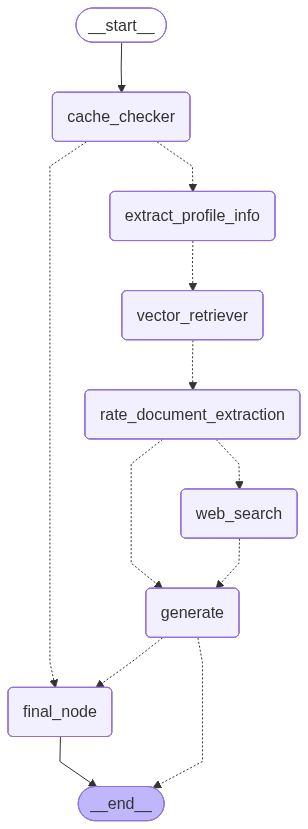

In [43]:
rag_app.load_store()

In [ ]:
if __name__ == "__main__":
    docs_path = "https://en.wikipedia.org/wiki/Northeast_India"

    rag_app = RAGApplication()
    query = "What was the cricket score in india vs Namibia?"
    # answer = rag_app.answer_question(question=query, chat_history="")
    # chatSessionListHandler = ChatSessionListHandler()
    # RAGRetriever()
    # username = "us"
    # password = "ps"
    # response = chatSessionListHandler.authenticate(username, password)
    x = 1
    #
    # rag_app.ingest_data(docs_path)
    # rag_app.load_store()
    #
    # pg_url = f"postgresql://{parser['POSTGRES']['username']}:{parser['POSTGRES']['password']}@{parser['POSTGRES']['hostname']}:{parser['POSTGRES']['port']}/{parser['POSTGRES']['database']}?sslmode=disable"
    # # logging.info(pg_url)
    # memory_connection_kwargs = {
    #     "autocommit": True,
    #     "prepare_threshold": 0
    # }
    # asyncio.run(config_pg_checkpointer())
    # asyncio.run(config_pg_store())
    # test_load_pg_store()

    # username = "us"
    # password = "ps"
    # chatSessionListHandler.authenticate(username=username, password=password)

    # logging.info("About to connect")
    # pool = Connection.connect(pg_url)
    # logging.info("Connected")
    # checkpointer = PostgresSaver(pool)
    # checkpointer.setup()
    # query = "What was the cricket score in india vs Namibia?"
    query = "Major mountains peaks in the North East?"
    # query = "What are the major travelling destinations in North East?"
    # asyncio.run(query_data(query))
    # while True:
    #     # query = input("question - ")
    #     query = "Which is the highest peak in Northeast?"
    #     # query = "What is the longest river in Earth"
    #     if query.lower() in ["exit", "quit"]:
    #         break
        # answer = rag_app.answer_question(question=query, chat_history="")
        # logging.info("\nAnswer:", answer, "\n")

    # embedding = OpenAIEmbeddings(dimensions=768, model="text-embedding-3-small")
    #
    # from redisvl.extensions.cache.llm import SemanticCache

    # llmcache = SemanticCache(
    #     name="llmcache",
    #     vectorizer=hf,  # Your HuggingFace vectorizer
    #     redis_url=REDIS_URL,
    #     ttl=300,  # Cache entries expire after 5 minutes
    #     distance_threshold=0.2,  # Similarity threshold
    #     overwrite=True
    # )
    # redis_client = redis.Redis(host=parser['CACHE']['cache_url'], port=parser['CACHE']['cache_port'],
    #                            db=parser['CACHE']['cache_db'], password=parser['CACHE']['cache_password'])
    #
    # llmcache = SemanticCache(
    #     name="llmcache",  # The name of the search index in Redis
    #     # redis_url="redis://103.180.212.180:6379",  # Connection URL for Redis
    #     redis_client=redis_client,
    #     distance_threshold=0.1  # Similarity threshold for cache matching
    # )

    # def answer_question_with_cache(query_text):
    #     start_time = time.time()
    #
    #     # Embed the query
    #     query_vector = embed_query(query_text)
    #
    #     # Check cache first
    #     cached_result = llmcache.check(vector=query_vector)
    #
    #     if cached_result:
    #         # Cache hit - return immediately
    #         elapsed = time.time() - start_time
    #         print(f"Cache HIT - Response time: {elapsed:.2f}s")
    #         return cached_result[0]['response']
    #
    #     # Cache miss - run full RAG pipeline
    #     # answer = await answer_question(index, query_text)
    #     answer = "Here is the sample result for the query - " + query_text
    #
    #     # Store in cache for future queries
    #     llmcache.store(
    #         prompt=query_text,
    #         response=answer,
    #         vector=query_vector
    #     )
    #
    #     elapsed = time.time() - start_time
    #     print(f"Cache MISS - Response time: {elapsed:.2f}s")
    #     return answer

    # query = "Which is the longest river in the world?"
    # embds.append(embed_query(query))
    # query = "What is the longest river in Earth"
    # query = "Tell me the name of the longest river in the world."
    # embds.append(embed_query(query))
    # x = 1
    # answer = answer_question_with_cache(query)
    # print(answer)